## Part II: Predicting Hall of Fame Careers

# Try the model without using cross val predict.  Split into train and test like in part I to get the model right... then figure out cross val predict.

In [421]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

In [422]:
queryMaster = 'select playerID,nameFirst,nameLast,bats,throws,debut,finalGame from Master;'
queryFielding = 'select * from Fielding;'
queryAwards = 'select playerID,awardID,yearID from AwardsPlayers;'
queryAllStar = 'select playerID, YearID from AllstarFull;'
queryHOF = '''select playerID,yearid,votedBy,needed_note from HallofFame where (votedBy == "BBWAA" or votedBy == "Old Timers" or votedBy == "Run Off" or votedBy == "Veterans") 
and inducted == "Y" and category == "Player";'''

In [423]:
batting_df = pd.read_csv('Batting.csv')

In [424]:
master = conn.execute(queryMaster).fetchall()
master_df = pd.DataFrame(master)
fielding = conn.execute(queryFielding).fetchall()
fielding_df = pd.DataFrame(fielding)
awards = conn.execute(queryAwards).fetchall()
awards_df = pd.DataFrame(awards)
allstar = conn.execute(queryAllStar).fetchall()
allstar_df = pd.DataFrame(allstar)
hof = conn.execute(queryHOF).fetchall()
hof_df = pd.DataFrame(hof)

In [425]:
master_cols = ['playerID','nameFirst','nameLast','bats','throws','debut','finalGame']
master_df.columns = master_cols

fielding_cols = ['playerID','yearID','stint','teamID','lgID','Pos','G','GS','InnOuts','PO','A','E','DP','PB','WP','SB','CS','ZR']
fielding_df.columns = fielding_cols

awards_cols = ['playerID','awardID','yearID']
awards_df.columns = awards_cols

allstar_cols = ['playerID','YearID']
allstar_df.columns = allstar_cols

hof_cols = ['playerID','yearid','votedBy','needed_note']
hof_df.columns = hof_cols

In [426]:
print(hof_df)

      playerID  yearid     votedBy needed_note
0    aaronha01    1982       BBWAA        None
1    alexape01    1938       BBWAA        None
2    alomaro01    2011       BBWAA        None
3    ansonca01    1939  Old Timers        None
4    aparilu01    1984       BBWAA        None
5    applilu01    1964     Run Off         1st
6    ashburi01    1995    Veterans        None
7    averiea01    1975    Veterans        None
8    bagweje01    2017       BBWAA        None
9    bakerfr01    1955    Veterans        None
10   bancrda01    1971    Veterans        None
11   bankser01    1977       BBWAA        None
12   becklja01    1971    Veterans        None
13   benchjo01    1989       BBWAA        None
14   bendech01    1953    Veterans        None
15   berrayo01    1972       BBWAA        None
16   biggicr01    2015       BBWAA        None
17   blylebe01    2011       BBWAA        None
18   boggswa01    2005       BBWAA        None
19   bottoji01    1974    Veterans        None
20   boudrlo0

In [427]:
print(hof_df['votedBy'].unique())

['BBWAA' 'Old Timers' 'Run Off' 'Veterans']


In [428]:
print(hof_df[hof_df['votedBy'] == 'Special Election'])

Empty DataFrame
Columns: [playerID, yearid, votedBy, needed_note]
Index: []


In [429]:
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


In [430]:
player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    G = row['G']
    AB = row['AB']
    R = row['R']
    H = row['H']
    twoB = row['2B']
    threeB = row['3B']
    HR = row['HR']
    RBI = row['RBI']
    SB = row['SB']
    CS = row['CS']
    BB = row['BB']
    SO = row['SO']
    IBB = row['IBB']
    HBP = row['HBP']
    SH = row['SH']
    SF = row['SF']
    GIDP = row['GIDP']
    yearID = row['yearID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + G
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + AB
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + R
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + H
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + twoB
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + threeB
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + HR
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + RBI
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + SB
        player_stats[playerID]['CS'] = player_stats[playerID]['CS'] + CS
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + BB
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + SO
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + IBB
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + HBP
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + SH
        player_stats[playerID]['GIDP'] = player_stats[playerID]['GIDP'] + GIDP
        years_played[playerID].append(yearID)        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = G
        player_stats[playerID]['AB'] = AB
        player_stats[playerID]['R'] = R
        player_stats[playerID]['H'] = H
        player_stats[playerID]['2B'] = twoB
        player_stats[playerID]['3B'] = threeB
        player_stats[playerID]['HR'] = HR
        player_stats[playerID]['RBI'] = RBI
        player_stats[playerID]['SB'] = SB
        player_stats[playerID]['CS'] = CS
        player_stats[playerID]['BB'] = BB
        player_stats[playerID]['SO'] = SO
        player_stats[playerID]['IBB'] = IBB
        player_stats[playerID]['HBP'] = HBP
        player_stats[playerID]['SH'] = SH
        player_stats[playerID]['GIDP'] = GIDP
        years_played[playerID] = []
        years_played[playerID].append(yearID)

In [431]:
eras_played = {}
for k, v in years_played.items():
    eras_played[k] = {}
    player_stats[k]['Years_Played'] = len(list(set(v)))
    for year in v:
        if year < 1920:
            eras_played[k]['pre1920'] = 1
        elif year >= 1920 and year <= 1941:
            eras_played[k]['1920-41'] = 1
        elif year >= 1942 and year <= 1945:
            eras_played[k]['1942-45'] = 1
        elif year >= 1946 and year <= 1962:
            eras_played[k]['1946-62'] = 1
        elif year >= 1963 and year <= 1976:
            eras_played[k]['1963-76'] = 1
        elif year >= 1977 and year <= 1992:
            eras_played[k]['1977-92'] = 1
        elif year >= 1993 and year <= 2009:
            eras_played[k]['1993-2009'] = 1

In [432]:
eras_df = pd.DataFrame.from_dict(eras_played, orient='index')

In [433]:
print(eras_df.head())

           pre1920  1920-41  1963-76  1946-62  1993-2009  1977-92  1942-45
aardsda01      NaN      NaN      NaN      NaN        1.0      NaN      NaN
aaronha01      NaN      NaN      1.0      1.0        NaN      NaN      NaN
aaronto01      NaN      NaN      1.0      1.0        NaN      NaN      NaN
aasedo01       NaN      NaN      NaN      NaN        NaN      1.0      NaN
abadan01       NaN      NaN      NaN      NaN        1.0      NaN      NaN


## Add in years played and eras played in.

In [434]:
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    InnOutsf = row['InnOuts']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    PBfc = row['PB']
    WPfc = row['WP']
    SBfc = row['SB']
    CSfc = row['CS']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['InnOutsf'] = player_stats[playerID]['InnOutsf'] + InnOutsf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
        player_stats[playerID]['PBfc'] = player_stats[playerID]['PBfc'] + PBfc
        player_stats[playerID]['WPfc'] = player_stats[playerID]['WPfc'] + WPfc
        player_stats[playerID]['SBfc'] = player_stats[playerID]['SBfc'] + SBfc
        player_stats[playerID]['CSfc'] = player_stats[playerID]['CSfc'] + CSfc
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['InnOutsf'] = InnOutsf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf
        player_stats[playerID]['PBfc'] = PBfc
        player_stats[playerID]['WPfc'] = WPfc
        player_stats[playerID]['SBfc'] = SBfc
        player_stats[playerID]['CSfc'] = CSfc

In [435]:
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


In [436]:
mvp_df = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy_df = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg_df = awards_df[awards_df['awardID'] == 'Gold Glove']
ss_df = awards_df[awards_df['awardID'] == 'Silver Slugger']

awards_list = [mvp_df,roy_df,gg_df,ss_df]

In [437]:
print(awards_list[1].head())

       playerID             awardID  yearID
1796  robinja02  Rookie of the Year    1947
1845   darkal01  Rookie of the Year    1948
1899  sievero01  Rookie of the Year    1949
1900  newcodo01  Rookie of the Year    1949
1953  dropowa01  Rookie of the Year    1950


In [438]:
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
lists = [mvp_list,roy_list,gg_list,ss_list]

In [439]:
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

In [440]:
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

In [441]:
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1

In [442]:
print(hof_df)

      playerID  yearid     votedBy needed_note
0    aaronha01    1982       BBWAA        None
1    alexape01    1938       BBWAA        None
2    alomaro01    2011       BBWAA        None
3    ansonca01    1939  Old Timers        None
4    aparilu01    1984       BBWAA        None
5    applilu01    1964     Run Off         1st
6    ashburi01    1995    Veterans        None
7    averiea01    1975    Veterans        None
8    bagweje01    2017       BBWAA        None
9    bakerfr01    1955    Veterans        None
10   bancrda01    1971    Veterans        None
11   bankser01    1977       BBWAA        None
12   becklja01    1971    Veterans        None
13   benchjo01    1989       BBWAA        None
14   bendech01    1953    Veterans        None
15   berrayo01    1972       BBWAA        None
16   biggicr01    2015       BBWAA        None
17   blylebe01    2011       BBWAA        None
18   boggswa01    2005       BBWAA        None
19   bottoji01    1974    Veterans        None
20   boudrlo0

In [443]:
print(len(hof_df))
print(len(master_df))

227
19105


In [444]:
print(dict(list(player_stats.items())[0:2]))

{'carrle01': {'DPf': 3.0, 'R': 2, 'BB': 2, 'Gf': 10, 'RBI': 4.0, 'Ef': 5.0, 'IBB': nan, 'GIDP': nan, 'SO': nan, 'POf': 12, 'HBP': 2.0, '2B': 1, 'GSf': nan, 'CSfc': nan, 'SB': 0.0, 'Af': 19.0, 'SBfc': nan, 'AB': 28, 'InnOutsf': nan, 'Years_Played': 1, 'G': 9, 'PBfc': nan, '3B': 1, 'WPfc': nan, 'HR': 0, 'CS': nan, 'SH': 0.0, 'H': 7}, 'proctre01': {'DPf': 0.0, 'R': 0, 'BB': 0, 'Gf': 2, 'RBI': 0.0, 'Ef': 0.0, 'IBB': 0.0, 'GIDP': 0.0, 'SO': 0.0, 'POf': 0, 'HBP': 0.0, '2B': 0, 'GSf': nan, 'CSfc': nan, 'SB': 0.0, 'Af': 0.0, 'SBfc': nan, 'AB': 0, 'InnOutsf': nan, 'Years_Played': 1, 'G': 2, 'PBfc': nan, '3B': 0, 'WPfc': nan, 'HR': 0, 'CS': 0.0, 'SH': 0.0, 'H': 0}}


In [445]:
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')

In [446]:
stats_df['playerID'] = stats_df.index

In [447]:
print(stats_df.head())

             DPf     R    BB      Gf     RBI     Ef  IBB   GIDP      SO  \
aardsda01    2.0     0     0   331.0     0.0    3.0  0.0    0.0     2.0   
aaronha01  218.0  2174  1402  3020.0  2297.0  144.0  NaN  328.0  1383.0   
aaronto01  124.0   102    86   387.0    94.0   22.0  3.0   36.0   145.0   
aasedo01    10.0     0     0   448.0     0.0   13.0  0.0    0.0     3.0   
abadan01     3.0     1     4     9.0     0.0    1.0  0.0    1.0     5.0   

              POf    ...        CS    SH     H  AS_games  Silver Slugger  \
aardsda01    11.0    ...       0.0   1.0     0       NaN             NaN   
aaronha01  7436.0    ...      73.0  21.0  3771      25.0             NaN   
aaronto01  1317.0    ...       8.0   9.0   216       NaN             NaN   
aasedo01     67.0    ...       0.0   0.0     0       1.0             NaN   
abadan01     37.0    ...       1.0   0.0     2       NaN             NaN   

           Gold Glove  HoF  Rookie of the Year  Most Valuable Player  \
aardsda01         Na

In [448]:
hof_dftest = stats_df[stats_df['HoF'] == 1]
print(hof_dftest['playerID'])
print(len(hof_dftest))

aaronha01    aaronha01
alexape01    alexape01
alomaro01    alomaro01
ansonca01    ansonca01
aparilu01    aparilu01
applilu01    applilu01
ashburi01    ashburi01
averiea01    averiea01
bagweje01    bagweje01
bakerfr01    bakerfr01
bancrda01    bancrda01
bankser01    bankser01
becklja01    becklja01
benchjo01    benchjo01
bendech01    bendech01
berrayo01    berrayo01
biggicr01    biggicr01
blylebe01    blylebe01
boggswa01    boggswa01
bottoji01    bottoji01
boudrlo01    boudrlo01
bresnro01    bresnro01
brettge01    brettge01
brocklo01    brocklo01
broutda01    broutda01
brownmo01    brownmo01
bunniji01    bunniji01
burkeje01    burkeje01
camparo01    camparo01
carewro01    carewro01
               ...    
suttebr01    suttebr01
suttodo01    suttodo01
terrybi01    terrybi01
thomafr04    thomafr04
thompsa01    thompsa01
tinkejo01    tinkejo01
traynpi01    traynpi01
vanceda01    vanceda01
vaughar01    vaughar01
wadderu01    wadderu01
wagneho01    wagneho01
wallabo01    wallabo01
walshed01  

In [449]:
print(master_df.head())

    playerID nameFirst nameLast bats throws       debut   finalGame
0  aardsda01     David  Aardsma    R      R  2004-04-06  2015-08-23
1  aaronha01      Hank    Aaron    R      R  1954-04-13  1976-10-03
2  aaronto01    Tommie    Aaron    R      R  1962-04-10  1971-09-26
3   aasedo01       Don     Aase    R      R  1977-07-26  1990-10-03
4   abadan01      Andy     Abad    L      L  2001-09-10  2006-04-13


In [450]:
df = master_df.join(stats_df,on='playerID',how='inner',rsuffix='mstr')

In [451]:
print(df.head())
print(len(stats_df))
print(len(df))
print(len(master_df))

    playerID nameFirst nameLast bats throws       debut   finalGame    DPf  \
0  aardsda01     David  Aardsma    R      R  2004-04-06  2015-08-23    2.0   
1  aaronha01      Hank    Aaron    R      R  1954-04-13  1976-10-03  218.0   
2  aaronto01    Tommie    Aaron    R      R  1962-04-10  1971-09-26  124.0   
3   aasedo01       Don     Aase    R      R  1977-07-26  1990-10-03   10.0   
4   abadan01      Andy     Abad    L      L  2001-09-10  2006-04-13    3.0   

      R    BB      ...         CS    SH     H  AS_games  Silver Slugger  \
0     0     0      ...        0.0   1.0     0       NaN             NaN   
1  2174  1402      ...       73.0  21.0  3771      25.0             NaN   
2   102    86      ...        8.0   9.0   216       NaN             NaN   
3     0     0      ...        0.0   0.0     0       1.0             NaN   
4     1     4      ...        1.0   0.0     2       NaN             NaN   

   Gold Glove  HoF  Rookie of the Year  Most Valuable Player  playerIDmstr  
0  

In [452]:
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
        
df['bats_R'] = df['bats'].apply(bats_throws)
df['throws_R'] = df['throws'].apply(bats_throws)

In [453]:
pos_list = []
pos_dict = {}
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    games = row['G']
    pos = row['Pos']
    if playerID in pos_dict:
        if pos in pos_dict[playerID]:
            pos_dict[playerID][pos] = pos_dict[playerID][pos] + games
        else:
            pos_dict[playerID][pos] = games
    else:
        pos_dict[playerID] = {}
        pos_dict[playerID][pos] = games

In [454]:
print(len(player_stats))

18915


In [455]:
primary_pos_dict = {}
player_list = []
for k, v in pos_dict.items():
    playerID = k
    primary_pos_dict[playerID] = {}
    for key, val in v.items():
        primary_pos_dict[playerID]['game_count'] = 0
        if val > primary_pos_dict[playerID]['game_count']:
            primary_pos_dict[playerID]['pos'] = key
            primary_pos_dict[playerID]['game_count'] = val

In [456]:
print(len(primary_pos_dict))
print(primary_pos_dict)

18714
{'carrle01': {'pos': 'SS', 'game_count': 9}, 'proctre01': {'pos': 'P', 'game_count': 2}, 'rosarwi01': {'pos': '3B', 'game_count': 3}, 'anderge01': {'pos': 'OF', 'game_count': 261}, 'blashja01': {'pos': 'OF', 'game_count': 21}, 'mccorbi01': {'pos': 'P', 'game_count': 2}, 'salkero01': {'pos': 'P', 'game_count': 45}, 'yateski01': {'pos': 'P', 'game_count': 98}, 'murphro01': {'pos': 'P', 'game_count': 597}, 'mangule01': {'pos': 'P', 'game_count': 85}, 'bellhe01': {'pos': 'P', 'game_count': 590}, 'monrojo01': {'pos': 'SS', 'game_count': 1}, 'raglafr01': {'pos': 'P', 'game_count': 23}, 'berryjo03': {'pos': 'P', 'game_count': 133}, 'adkindo01': {'pos': 'P', 'game_count': 6}, 'torreyo01': {'pos': 'OF', 'game_count': 1}, 'chatwty01': {'pos': 'P', 'game_count': 97}, 'glennbo01': {'pos': 'P', 'game_count': 2}, 'bergejo01': {'pos': 'SS', 'game_count': 32}, 'smokejo01': {'pos': 'P', 'game_count': 20}, 'kempto01': {'pos': 'OF', 'game_count': 39}, 'berojo01': {'pos': 'SS', 'game_count': 55}, 't

In [457]:
primary_pos_df = pd.DataFrame.from_dict(primary_pos_dict, orient='index')

In [458]:
primary_pos_df = primary_pos_df.drop('game_count', axis=1)

In [459]:
df = df.join(primary_pos_df,on='playerID',how='inner')

In [460]:
dummy_df = pd.get_dummies(df['pos'], prefix='pos_')
df = pd.concat([df, dummy_df], axis=1)

In [461]:
from datetime import datetime
df['debut'] =  pd.to_datetime(df['debut'])
df['finalGame'] = pd.to_datetime(df['finalGame'])

In [462]:
df['debutYear'] = pd.to_numeric(df['debut'].dt.strftime('%Y'), errors='coerce')
df['finalYear'] = pd.to_numeric(df['finalGame'].dt.strftime('%Y'), errors='coerce')

In [463]:
df['YSR'] = 2016 - df['finalYear']

In [464]:
df = df[df['YSR'] > 15]

In [465]:
df['AVE'] = df['H'] / df['AB']

In [466]:
df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])

In [467]:
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR'])) / df['AB']

In [468]:
df['OPS'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR']) + df['BB']) / (df['AB'] + df['BB'])  

In [469]:
print(df.head())

    playerID nameFirst     nameLast bats throws      debut  finalGame    DPf  \
1  aaronha01      Hank        Aaron    R      R 1954-04-13 1976-10-03  218.0   
2  aaronto01    Tommie        Aaron    R      R 1962-04-10 1971-09-26  124.0   
3   aasedo01       Don         Aase    R      R 1977-07-26 1990-10-03   10.0   
6  abadijo01      John       Abadie    R      R 1875-04-26 1875-06-10    1.0   
7  abbated01        Ed  Abbaticchio    R      R 1897-09-04 1910-09-15  247.0   

      R    BB    ...     pos__OF  pos__P  pos__SS  debutYear  finalYear  \
1  2174  1402    ...         0.0     0.0      0.0     1954.0     1976.0   
2   102    86    ...         0.0     0.0      0.0     1962.0     1971.0   
3     0     0    ...         0.0     1.0      0.0     1977.0     1990.0   
6     4     0    ...         0.0     0.0      0.0     1875.0     1875.0   
7   355   289    ...         0.0     0.0      1.0     1897.0     1910.0   

     YSR       AVE       OBP  Slug_Percent       OPS  
1   40.0  0.3

In [470]:
df = df.join(eras_df,on='playerID',how='inner')

In [666]:
df_hitters = df[df['pos__P'] == 0]

In [669]:
df_hitters = df_hitters[(df_hitters['playerID'] != 'bendech01') & (df_hitters['playerID'] != 'clarkjo01') & 
(df_hitters['playerID'] != 'galvipu01') & (df_hitters['playerID'] != 'griffcl01') & 
(df_hitters['playerID'] != 'jossad01') & (df_hitters['playerID'] != 'keefeti01') &
(df_hitters['playerID'] != 'mcginjo01') & (df_hitters['playerID'] != 'radboch01')]

In [670]:
print(len(df_hitters))

7716


In [671]:
df_hof = df[df['HoF'] == 1]
print(df_hof)
print(len(df_hof))

        playerID nameFirst     nameLast bats throws      debut  finalGame  \
1      aaronha01      Hank        Aaron    R      R 1954-04-13 1976-10-03   
177    alexape01      Pete    Alexander    R      R 1911-04-15 1930-05-28   
389    ansonca01       Cap        Anson    R      R 1871-05-06 1897-10-03   
398    aparilu01      Luis     Aparicio    R      R 1956-04-17 1973-09-28   
405    applilu01      Luke      Appling    R      R 1930-09-10 1950-10-01   
480    ashburi01    Richie      Ashburn    L      R 1948-04-20 1962-09-30   
541    averiea01      Earl      Averill    L      R 1929-04-16 1941-04-25   
642    bakerfr01  Home Run        Baker    L      R 1908-09-21 1922-09-29   
702    bancrda01      Dave     Bancroft    B      R 1915-04-14 1930-05-31   
714    bankser01     Ernie        Banks    R      R 1953-09-17 1971-09-26   
1028   becklja01      Jake      Beckley    L      L 1888-06-20 1907-06-15   
1133   benchjo01    Johnny        Bench    R      R 1967-08-28 1983-09-29   

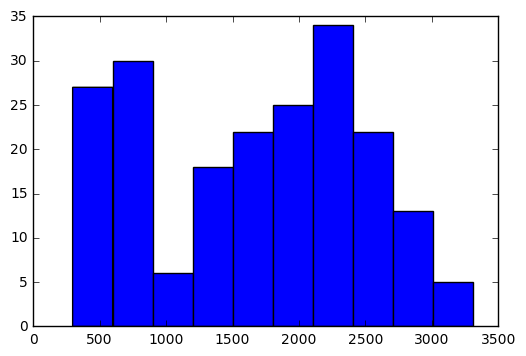

In [672]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_hof['G'])
plt.show()

In [673]:
print(df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'bats', 'throws', 'debut',
       'finalGame', 'DPf', 'R', 'BB', 'Gf', 'RBI', 'Ef', 'IBB', 'GIDP', 'SO',
       'POf', 'HBP', '2B', 'GSf', 'CSfc', 'SB', 'Af', 'SBfc', 'AB', 'InnOutsf',
       'Years_Played', 'G', 'PBfc', '3B', 'WPfc', 'HR', 'CS', 'SH', 'H',
       'AS_games', 'Silver Slugger', 'Gold Glove', 'HoF', 'Rookie of the Year',
       'Most Valuable Player', 'playerIDmstr', 'bats_R', 'throws_R', 'pos',
       'pos__1B', 'pos__2B', 'pos__3B', 'pos__C', 'pos__OF', 'pos__P',
       'pos__SS', 'debutYear', 'finalYear', 'YSR', 'AVE', 'OBP',
       'Slug_Percent', 'OPS', 'pre1920', '1920-41', '1963-76', '1946-62',
       '1993-2009', '1977-92', '1942-45'],
      dtype='object')


In [674]:
numeric_cols = ['Rp', 'SVp', 'RBI', 'BFPp', 'HRp', 'SHOp', 'CSfc', 'SB', 'GSp', 'CS', 'Ef', 'R', 'IPOutsp',
       'PBfc', 'BB', 'SBfc', 'Af', '2B', '3B', 'SO',
       'HR', 'CGp', 'WPfc', 'Lp', 'G', 'IBB',
       'H', 'SOp', 'AB', 'ERp', 'Wp', 'AS_games', 'HoF', 'Gold Glove', 'Rookie of the Year',
       'Silver Slugger', 'Most Valuable Player', 'Cy Young Award', 'bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__P', 'pos__SS', 'YSR', 'AVE']

In [675]:
numeric_cols1 = ['Rp', 'SVp', 'GIDP', 'RBI', 'IBBp', 'BFPp', 'InnOutsf',
       'HRp', 'SHOp', 'CSfc', 'SB', 'GSp', 'CS', 'Ef', 'R', 'BKp', 'IPOutsp',
       'WPp', 'PBfc', 'BB', 'SBfc', 'Af', 'HBPp', '2B', '3B', 'SFp', 'SO',
       'HR', 'DPf', 'POf', 'Gf', 'CGp', 'WPfc', 'Lp', 'Gp', 'SH', 'G', 'IBB',
       'H', 'SOp', 'AB', 'ERp', 'Hp', 'GSf', 'SHp', 'HBP', 'BBp', 'GIDPp',
       'Wp', 'GFp', 'AS_games', 'HoF', 'Gold Glove', 'Rookie of the Year',
       'Silver Slugger', 'Most Valuable Player', 'Cy Young Award', 'bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__P', 'pos__SS', 'YSR', 'AVE']

In [676]:
num_cols_hitters_w_fielding = ['SB','CS','R','BB','SBfc', 'Af', '2B', '3B','HR',
       'WPfc','G', 'IBB', 'H', 'AB', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'Most Valuable Player','bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent']

In [707]:
num_cols_hitters = ['SB','CS','R','BB', '2B', '3B','HR', 'RBI',
       'G', 'IBB', 'H', 'AB', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'Most Valuable Player','bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent']
data = df_hitters[num_cols_hitters]

In [708]:
data = data.fillna(0)

In [709]:
data_hof = data[data['HoF'] == 1]

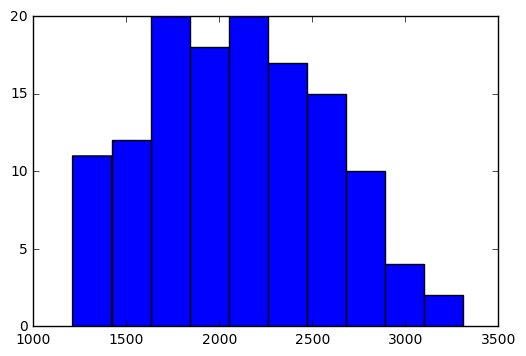

In [710]:
plt.hist(data_hof['G'])
plt.show()

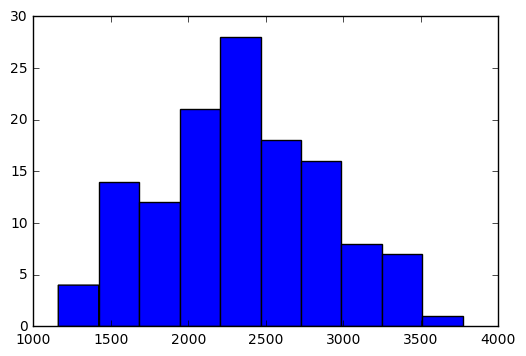

In [711]:
plt.hist(data_hof['H'])
plt.show()

In [712]:
print(data_hof[data_hof['H'] < 1500])

          SB   CS     R    BB   2B  3B   HR     RBI     G  IBB      ...       \
1856   212.0  0.0   682   714  218  71   26   530.0  1446  0.0      ...        
2486    25.0  0.0   627   533  178  18  242   856.0  1215  0.0      ...        
2864   401.0  0.0   797   554  200  79   20   596.0  1287  0.0      ...        
6890    70.0  0.0   777   372  341  67  164   833.0  1283  0.0      ...        
9123    22.0  0.0   971  1011  216  39  369  1015.0  1472  0.0      ...        
11043    0.0  0.0  1069   537  192  53   44     0.0  1275  0.0      ...        
15304  177.0  0.0   579   638  199  49   11   594.0  1762  0.0      ...        
18608   52.0  0.0   884   674  266  67  244  1063.0  1348  0.0      ...        
19004  153.0  0.0   812   550  236  93   42   592.0  1211  0.0      ...        

       pre1920  1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  \
1856       1.0      0.0      0.0      0.0      0.0      0.0        0.0   
2486       0.0      0.0      0.0      1.0      0.0 

In [713]:
print(df_hof['playerID'].tail(60))


13907    puckeki01
14010    radboch01
14229    reesepe01
14390     riceji01
14393     ricesa01
14542    rixeyep01
14546    rizzuph01
14597    roberro01
14609    robinbr01
14623    robinfr02
14627    robinja02
14900    roushed01
14959    ruffire01
14984    rusieam01
15008     ruthba01
15036     ryanno01
15153    sandbry01
15212    santoro01
15304    schalra01
15387    schmimi01
15403    schoere01
15533    seaveto01
15617    seweljo01
15867    simmoal01
15922    sislege01
15967    slaugen01
16116    smithoz01
16176    snidedu01
16279    spahnwa01
16292    speaktr01
16435    stargwi01
16822    suttebr01
16825    suttodo01
17080    terrybi01
17208    thompsa01
17275    tinkejo01
17405    traynpi01
17647    vanceda01
17698    vaughar01
17848    wadderu01
17869    wagneho01
17944    wallabo01
17977    walshed01
18007    wanerll01
18008    wanerpa01
18029     wardjo01
18205    welchmi01
18296    wheatza01
18335    whitede01
18437    wilheho01
18473    willibi01
18555    willite01
18559    wil

In [714]:
print(df.loc[8283])

playerID                          irvinmo01
nameFirst                             Monte
nameLast                              Irvin
bats                                      R
throws                                    R
debut                   1949-07-08 00:00:00
finalGame               1956-09-30 00:00:00
DPf                                     121
R                                       366
BB                                      351
Gf                                      696
RBI                                     443
Ef                                       43
IBB                                     NaN
GIDP                                     81
SO                                      220
POf                                    2084
HBP                                      23
2B                                       97
GSf                                     NaN
CSfc                                    NaN
SB                                       28
Af                              

In [715]:
print(data_hof[data_hof['G'] < 1500])

          SB    CS     R    BB   2B   3B   HR     RBI     G  IBB  \
1856   212.0   0.0   682   714  218   71   26   530.0  1446  0.0   
2486    25.0   0.0   627   533  178   18  242   856.0  1215  0.0   
2864   401.0   0.0   797   554  200   79   20   596.0  1287  0.0   
3188    64.0  46.0  1041   857  333   64  119   832.0  1482  0.0   
3310    96.0  71.0  1186   670  309  154   58   632.0  1455  0.0   
5144     0.0   0.0  1129   392  250  178   71   883.0  1315  0.0   
5483   330.0   0.0   950   597  268  164   48   756.0  1483  0.0   
6624    58.0   0.0  1051   852  379   71  331  1276.0  1394  0.0   
6890    70.0   0.0   777   372  341   67  164   833.0  1283  0.0   
8449   359.0   0.0   994   347  232   88   18   840.0  1285  0.0   
8968     0.0   0.0  1357   549  359  102   69   950.0  1455  0.0   
9123    22.0   0.0   971  1011  216   39  369  1015.0  1472  0.0   
10013   84.0   0.0   895   334  301   81  103   779.0  1438  0.0   
11043    0.0   0.0  1069   537  192   53   44   

In [716]:
print(data_hof['H'])

1        3771
389      3418
398      2677
405      2749
480      2574
541      2019
642      1838
702      2004
714      2583
1133     2048
1232     2150
1646     2313
1653     1779
1856     1252
1860     3154
1935     3023
1969     2296
2228     2850
2486     1161
2581     3053
2583     2665
2682     2092
2820     2351
2864     1273
3062     2672
3188     1652
3270     3315
3274     1999
3310     1866
3376     2467
         ... 
15153    2386
15212    2254
15304    1345
15387    2234
15403    2449
15617    2226
15867    2927
15922    2812
15967    2383
16116    2460
16176    2116
16435    2232
17080    2193
17208    1979
17275    1687
17405    2416
17698    2103
17869    3415
17944    2309
18007    2459
18008    3152
18029    2104
18296    2884
18335    2066
18473    2711
18608    1461
18665    3110
18916    3419
19004    1491
19011    3142
Name: H, dtype: int64


In [717]:
print(df_hof['H'])

1        3771
177       378
389      3418
398      2677
405      2749
480      2574
541      2019
642      1838
702      2004
714      2583
1028     2930
1133     2048
1134      243
1232     2150
1481       59
1515     3010
1646     2313
1653     1779
1856     1252
1860     3154
1935     3023
1969     2296
2050      235
2191      213
2228     2850
2486     1161
2581     3053
2583     2665
2608      346
2682     2092
         ... 
16435    2232
16822       9
16825     195
17080    2193
17208    1979
17275    1687
17405    2416
17647     146
17698    2103
17848     172
17869    3415
17944    2309
17977     210
18007    2459
18008    3152
18029    2104
18205     492
18296    2884
18335    2066
18437      38
18473    2711
18555    2654
18559     248
18608    1461
18665    3110
18896     365
18916    3419
18971     623
19004    1491
19011    3142
Name: H, dtype: int64


In [718]:
# Split data DataFrame into train and test sets
train = data.sample(frac=0.60, random_state=1)
test = data.loc[~data.index.isin(train.index)]

In [719]:
target = data['HoF']
features = data.drop('HoF', axis=1)

In [720]:
train_target_t = train['HoF']
train_features_t = train.drop('HoF', axis=1)
test_target_t = test['HoF']
test_features_t = test.drop('HoF', axis=1)

In [721]:
print(len(data))

7716


## Don't forget to deal with class imbalance.

In [722]:
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

In [723]:
tn_filter = (predictions == 0) & (data['HoF'] == 0)
tn = len(predictions[tn_filter])

tp_filter = (predictions == 1) & (data['HoF'] == 1)
tp = len(predictions[tp_filter])

fn_filter = (predictions == 0) & (data['HoF'] == 1)
fn = len(predictions[fn_filter])

fp_filter = (predictions == 1) & (data['HoF'] == 0)
fp = len(predictions[fp_filter])

In [724]:
print(tn)
print(tp)
print(fn)
print(fp)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
print(fpr)
print(tpr)

2912
2
56
116
0.03830911492734478
0.034482758620689655


In [725]:
len(train_target_t)

4630

In [726]:
lr.fit(train_features_t, train_target_t)
test_predictions = lr.predict(test_features_t)

In [727]:
test_predictions = pd.Series(test_predictions)

tn_filter = (test_predictions == 0) & (test_target_t == 0)
tn = len(test_predictions[tn_filter])

tp_filter = (test_predictions == 1) & (test_target_t == 1)
tp = len(test_predictions[tp_filter])

fn_filter = (test_predictions == 0) & (test_target_t == 1)
fn = len(test_predictions[fn_filter])

fp_filter = (test_predictions == 1) & (test_target_t == 0)
fp = len(test_predictions[fp_filter])

In [728]:
print(tn)
print(tp)
print(fn)
print(fp)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
print(fpr)
print(tpr)

467
1
15
15
0.03112033195020747
0.0625


In [729]:
print(len(target))
print(len(df))
print(len(predictions))

7716
14070
7716


In [730]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, class_weight='balanced')
predictions = cross_val_predict(rf, features, target, cv=kf)
predictions= pd.Series(predictions)

In [731]:
tn_filter = (predictions == 0) & (data['HoF'] == 0)
tn = len(predictions[tn_filter])

tp_filter = (predictions == 1) & (data['HoF'] == 1)
tp = len(predictions[tp_filter])

fn_filter = (predictions == 0) & (data['HoF'] == 1)
fn = len(predictions[fn_filter])

fp_filter = (predictions == 1) & (data['HoF'] == 0)
fp = len(predictions[fp_filter])

In [732]:
print(tn)
print(tp)
print(fn)
print(fp)

2996
1
57
32


In [733]:
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

In [734]:
print(fpr)
print(tpr)

0.010568031704095112
0.017241379310344827
